In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-02 22:01:51.476241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 22:01:51.480316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 22:01:51.480648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-02 22:01:51.753275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 22:01:51.754046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 22:01:51.754393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 22:01:51.754670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[3.28662186e+01, 1.98073807e+01, 1.92437401e+01],
         [3.61974525e+01, 2.17906914e+01, 2.41307583e+01],
         [3.34395943e+01, 2.35048695e+01, 2.60881615e+01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [2.16428590e+00, 2.72333407e+00, 0.00000000e+00],
         [0.00000000e+00, 9.97452199e-01, 0.00000000e+00]],

        [[2.64316959e+01, 2.27393322e+01, 2.23639908e+01],
         [3.28888893e+01, 2.40784492e+01, 2.47012215e+01],
         [3.09661560e+01, 2.75285950e+01, 2.85614986e+01],
         ...,
         [2.40295798e-01, 2.72449255e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 9.42716956e-01],
         [0.00000000e+00, 0.00000000e+00, 1.41744685e+00]],

        [[2.72665291e+01, 2.30340233e+01, 2.27724571e+01],
         [3.14395943e+01, 2.27555065e+01, 2.68880978e+01],
         [2.94513741e+01, 2.30400887e+01, 2.02192039e+01],
         ...,
         [0

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[3.28662186e+01, 1.98073807e+01, 1.92437401e+01],
          [3.61974525e+01, 2.17906914e+01, 2.41307583e+01],
          [3.34395943e+01, 2.35048695e+01, 2.60881615e+01],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [2.16428590e+00, 2.72333407e+00, 0.00000000e+00],
          [0.00000000e+00, 9.97452199e-01, 0.00000000e+00]],
 
         [[2.64316959e+01, 2.27393322e+01, 2.23639908e+01],
          [3.28888893e+01, 2.40784492e+01, 2.47012215e+01],
          [3.09661560e+01, 2.75285950e+01, 2.85614986e+01],
          ...,
          [2.40295798e-01, 2.72449255e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 9.42716956e-01],
          [0.00000000e+00, 0.00000000e+00, 1.41744685e+00]],
 
         [[2.72665291e+01, 2.30340233e+01, 2.27724571e+01],
          [3.14395943e+01, 2.27555065e+01, 2.68880978e+01],
          [2.94513741e+01, 2.30400887e+01, 2.02192039e+0

<IPython.core.display.Javascript object>


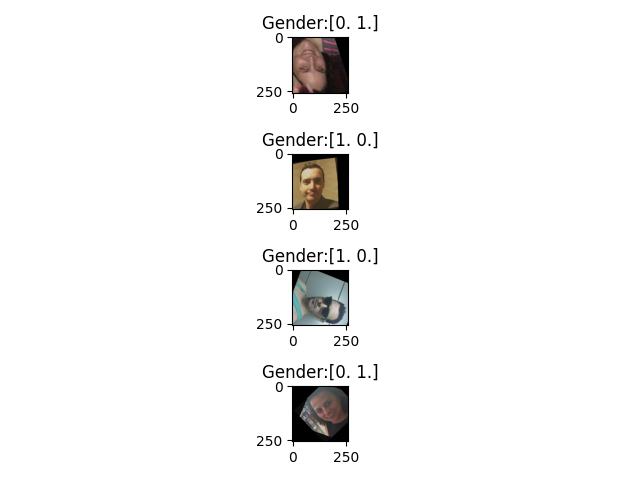

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_8')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 64

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 64)           1001856     ['tf.math.subtract[0][0]']    

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_8"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-02 22:01:55.344345: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-02 22:01:55.344369: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-02 22:01:55.344388: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-02 22:01:55.421224: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-02 22:01:55.422507: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-02 22:01:56.034672: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  13/3528 [..............................] - ETA: 14s - loss: 7153.8101 - gender_out_loss: 0.6954 - tf.math.multiply_1_loss: 5415.4272 - gender_out_accuracy: 0.4038    

2022-11-02 22:01:56.771152: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 15s 4ms/step - loss: 7723.3545 - gender_out_loss: 0.6930 - tf.math.multiply_1_loss: 5990.8379 - gender_out_accuracy: 0.5195
Epoch 1/300
   1/1000 [..............................] - ETA: 13:39 - loss: 9565.1553 - gender_out_loss: 0.7133 - tf.math.multiply_1_loss: 7781.9956 - gender_out_accuracy: 0.5000

2022-11-02 22:02:11.165646: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-02 22:02:11.165737: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   8/1000 [..............................] - ETA: 1:15 - loss: 9156.4375 - gender_out_loss: 0.6620 - tf.math.multiply_1_loss: 7501.3779 - gender_out_accuracy: 0.7812

2022-11-02 22:02:11.700479: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-02 22:02:11.701654: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-02 22:02:11.737608: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3188 callback api events and 3147 activity events. 
2022-11-02 22:02:11.766457: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-02 22:02:11.808198: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_8/log_0/plugins/profile/2022_11_02_22_02_11

2022-11-02 22:02:11.865567: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_8/log_0/plugins/profile/2022_11_02_22_02_11/rachanon-pc1.trace.json.gz


  30/1000 [..............................] - ETA: 31s - loss: 8812.7002 - gender_out_loss: 0.6662 - tf.math.multiply_1_loss: 7147.0991 - gender_out_accuracy: 0.6333

2022-11-02 22:02:11.908743: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_8/log_0/plugins/profile/2022_11_02_22_02_11

2022-11-02 22:02:11.914153: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to log/AE_8/log_0/plugins/profile/2022_11_02_22_02_11/rachanon-pc1.memory_profile.json.gz
2022-11-02 22:02:11.915138: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: log/AE_8/log_0/plugins/profile/2022_11_02_22_02_11
Dumped tool data for xplane.pb to log/AE_8/log_0/plugins/profile/2022_11_02_22_02_11/rachanon-pc1.xplane.pb
Dumped tool data for overview_page.pb to log/AE_8/log_0/plugins/profile/2022_11_02_22_02_11/rachanon-pc1.overview_page.pb
Dumped tool data for input_pipeline.pb to log/AE_8/log_0/plugins/profile/2022_11_02_22_02_11/rachanon-pc1.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to log/AE_8/log_0/plugins/profile/2022_11_02_22_02_11/ra

1000/1000 [==============================] - 22s 21ms/step - loss: 4563.2949 - gender_out_loss: 0.6758 - tf.math.multiply_1_loss: 2873.8154 - gender_out_accuracy: 0.5857 - val_loss: 3935.0571 - val_gender_out_loss: 0.6821 - val_tf.math.multiply_1_loss: 2229.8657 - val_gender_out_accuracy: 0.5676
Epoch 2/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3321.8115 - gender_out_loss: 0.6591 - tf.math.multiply_1_loss: 1674.1732 - gender_out_accuracy: 0.6177 - val_loss: 3451.1697 - val_gender_out_loss: 0.6808 - val_tf.math.multiply_1_loss: 1749.1991 - val_gender_out_accuracy: 0.5660
Epoch 3/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3069.2625 - gender_out_loss: 0.6496 - tf.math.multiply_1_loss: 1445.3140 - gender_out_accuracy: 0.6035 - val_loss: 3271.1719 - val_gender_out_loss: 0.6825 - val_tf.math.multiply_1_loss: 1564.8094 - val_gender_out_accuracy: 0.5744
Epoch 4/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2978.7

1000/1000 [==============================] - 21s 21ms/step - loss: 2467.0383 - gender_out_loss: 0.6287 - tf.math.multiply_1_loss: 895.1782 - gender_out_accuracy: 0.6438 - val_loss: 3012.0535 - val_gender_out_loss: 0.7547 - val_tf.math.multiply_1_loss: 1125.2782 - val_gender_out_accuracy: 0.5435
Epoch 28/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2607.2573 - gender_out_loss: 0.6674 - tf.math.multiply_1_loss: 938.6877 - gender_out_accuracy: 0.5918 - val_loss: 2846.9009 - val_gender_out_loss: 0.6917 - val_tf.math.multiply_1_loss: 1117.6852 - val_gender_out_accuracy: 0.5513
Epoch 29/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2542.7947 - gender_out_loss: 0.6492 - tf.math.multiply_1_loss: 919.7971 - gender_out_accuracy: 0.6122 - val_loss: 2767.8599 - val_gender_out_loss: 0.6689 - val_tf.math.multiply_1_loss: 1095.6857 - val_gender_out_accuracy: 0.5962
Epoch 30/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2513.6

1000/1000 [==============================] - 21s 21ms/step - loss: 2443.0581 - gender_out_loss: 0.6454 - tf.math.multiply_1_loss: 829.4968 - gender_out_accuracy: 0.6300 - val_loss: 2746.3284 - val_gender_out_loss: 0.6941 - val_tf.math.multiply_1_loss: 1011.0078 - val_gender_out_accuracy: 0.5836
Epoch 54/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2356.5439 - gender_out_loss: 0.6239 - tf.math.multiply_1_loss: 796.7606 - gender_out_accuracy: 0.6547 - val_loss: 2632.7026 - val_gender_out_loss: 0.6337 - val_tf.math.multiply_1_loss: 1048.5168 - val_gender_out_accuracy: 0.6416
Epoch 55/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2376.8081 - gender_out_loss: 0.6220 - tf.math.multiply_1_loss: 821.8976 - gender_out_accuracy: 0.6540 - val_loss: 2614.5408 - val_gender_out_loss: 0.6494 - val_tf.math.multiply_1_loss: 990.9560 - val_gender_out_accuracy: 0.6261
Epoch 56/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2357.50

Epoch 80/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2206.2524 - gender_out_loss: 0.5738 - tf.math.multiply_1_loss: 771.7091 - gender_out_accuracy: 0.6955 - val_loss: 2744.0708 - val_gender_out_loss: 0.6979 - val_tf.math.multiply_1_loss: 999.3334 - val_gender_out_accuracy: 0.6259
Epoch 81/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2381.9980 - gender_out_loss: 0.6225 - tf.math.multiply_1_loss: 825.6682 - gender_out_accuracy: 0.6557 - val_loss: 2514.2825 - val_gender_out_loss: 0.6172 - val_tf.math.multiply_1_loss: 971.3347 - val_gender_out_accuracy: 0.6530
Epoch 82/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2316.9561 - gender_out_loss: 0.6133 - tf.math.multiply_1_loss: 783.8147 - gender_out_accuracy: 0.6578 - val_loss: 2478.2788 - val_gender_out_loss: 0.6082 - val_tf.math.multiply_1_loss: 957.7374 - val_gender_out_accuracy: 0.6695
Epoch 83/300
1000/1000 [==============================] - 21s 21ms/step - lo

Epoch 107/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2199.8887 - gender_out_loss: 0.5736 - tf.math.multiply_1_loss: 765.9026 - gender_out_accuracy: 0.7053 - val_loss: 2453.8472 - val_gender_out_loss: 0.6010 - val_tf.math.multiply_1_loss: 951.3845 - val_gender_out_accuracy: 0.6753
Epoch 108/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2251.7510 - gender_out_loss: 0.5914 - tf.math.multiply_1_loss: 773.1423 - gender_out_accuracy: 0.6695 - val_loss: 2431.5525 - val_gender_out_loss: 0.5909 - val_tf.math.multiply_1_loss: 954.2914 - val_gender_out_accuracy: 0.6843
Epoch 109/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2220.2795 - gender_out_loss: 0.5719 - tf.math.multiply_1_loss: 790.4313 - gender_out_accuracy: 0.6988 - val_loss: 2473.6628 - val_gender_out_loss: 0.6095 - val_tf.math.multiply_1_loss: 949.9178 - val_gender_out_accuracy: 0.6756
Epoch 110/300
1000/1000 [==============================] - 21s 21ms/step 

1000/1000 [==============================] - 21s 21ms/step - loss: 2115.9385 - gender_out_loss: 0.5456 - tf.math.multiply_1_loss: 751.9885 - gender_out_accuracy: 0.7230 - val_loss: 2942.3857 - val_gender_out_loss: 0.7876 - val_tf.math.multiply_1_loss: 973.3569 - val_gender_out_accuracy: 0.6098
Epoch 134/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2256.7642 - gender_out_loss: 0.5857 - tf.math.multiply_1_loss: 792.4287 - gender_out_accuracy: 0.6870 - val_loss: 2359.8330 - val_gender_out_loss: 0.5649 - val_tf.math.multiply_1_loss: 947.4708 - val_gender_out_accuracy: 0.7051
Epoch 135/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2176.0151 - gender_out_loss: 0.5629 - tf.math.multiply_1_loss: 768.7847 - gender_out_accuracy: 0.7132 - val_loss: 2352.0232 - val_gender_out_loss: 0.5614 - val_tf.math.multiply_1_loss: 948.5482 - val_gender_out_accuracy: 0.7125
Epoch 136/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2122.2

1000/1000 [==============================] - 21s 21ms/step - loss: 2140.3857 - gender_out_loss: 0.5506 - tf.math.multiply_1_loss: 763.9299 - gender_out_accuracy: 0.7255 - val_loss: 2367.4287 - val_gender_out_loss: 0.5645 - val_tf.math.multiply_1_loss: 956.2863 - val_gender_out_accuracy: 0.7118
Epoch 160/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2041.1603 - gender_out_loss: 0.5158 - tf.math.multiply_1_loss: 751.5350 - gender_out_accuracy: 0.7470 - val_loss: 2812.1350 - val_gender_out_loss: 0.7408 - val_tf.math.multiply_1_loss: 960.2561 - val_gender_out_accuracy: 0.6337
Epoch 161/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2078.6165 - gender_out_loss: 0.5376 - tf.math.multiply_1_loss: 734.6948 - gender_out_accuracy: 0.7258 - val_loss: 3148.7327 - val_gender_out_loss: 0.8819 - val_tf.math.multiply_1_loss: 944.0314 - val_gender_out_accuracy: 0.5877
Epoch 162/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2153.2

1000/1000 [==============================] - 21s 21ms/step - loss: 2014.8113 - gender_out_loss: 0.5049 - tf.math.multiply_1_loss: 752.4620 - gender_out_accuracy: 0.7582 - val_loss: 2630.1421 - val_gender_out_loss: 0.6757 - val_tf.math.multiply_1_loss: 940.8353 - val_gender_out_accuracy: 0.6537
Epoch 186/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1992.9103 - gender_out_loss: 0.5001 - tf.math.multiply_1_loss: 742.6039 - gender_out_accuracy: 0.7545 - val_loss: 2384.2087 - val_gender_out_loss: 0.5768 - val_tf.math.multiply_1_loss: 942.2659 - val_gender_out_accuracy: 0.7133
Epoch 187/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2161.6794 - gender_out_loss: 0.5518 - tf.math.multiply_1_loss: 782.2520 - gender_out_accuracy: 0.7155 - val_loss: 2241.4243 - val_gender_out_loss: 0.5160 - val_tf.math.multiply_1_loss: 951.3562 - val_gender_out_accuracy: 0.7447
Epoch 188/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1977.3

1000/1000 [==============================] - 21s 21ms/step - loss: 1984.0759 - gender_out_loss: 0.4970 - tf.math.multiply_1_loss: 741.6152 - gender_out_accuracy: 0.7502 - val_loss: 2194.4141 - val_gender_out_loss: 0.4989 - val_tf.math.multiply_1_loss: 947.1193 - val_gender_out_accuracy: 0.7579
Epoch 212/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2028.2697 - gender_out_loss: 0.5010 - tf.math.multiply_1_loss: 775.8464 - gender_out_accuracy: 0.7530 - val_loss: 2611.2703 - val_gender_out_loss: 0.6669 - val_tf.math.multiply_1_loss: 944.1060 - val_gender_out_accuracy: 0.6581
Epoch 213/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1915.7936 - gender_out_loss: 0.4702 - tf.math.multiply_1_loss: 740.1736 - gender_out_accuracy: 0.7780 - val_loss: 2195.5542 - val_gender_out_loss: 0.5010 - val_tf.math.multiply_1_loss: 943.0911 - val_gender_out_accuracy: 0.7543
Epoch 214/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1934.8

1000/1000 [==============================] - 21s 21ms/step - loss: 1902.3065 - gender_out_loss: 0.4590 - tf.math.multiply_1_loss: 754.7136 - gender_out_accuracy: 0.7818 - val_loss: 2145.4360 - val_gender_out_loss: 0.4854 - val_tf.math.multiply_1_loss: 931.8226 - val_gender_out_accuracy: 0.7587
Epoch 238/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1866.9724 - gender_out_loss: 0.4383 - tf.math.multiply_1_loss: 771.2971 - gender_out_accuracy: 0.7965 - val_loss: 2073.9280 - val_gender_out_loss: 0.4565 - val_tf.math.multiply_1_loss: 932.7526 - val_gender_out_accuracy: 0.7795
Epoch 239/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1892.8020 - gender_out_loss: 0.4590 - tf.math.multiply_1_loss: 745.3184 - gender_out_accuracy: 0.7775 - val_loss: 2124.9307 - val_gender_out_loss: 0.4665 - val_tf.math.multiply_1_loss: 958.8079 - val_gender_out_accuracy: 0.7754
Epoch 240/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1982.5

1000/1000 [==============================] - 21s 21ms/step - loss: 1844.2579 - gender_out_loss: 0.4296 - tf.math.multiply_1_loss: 770.1636 - gender_out_accuracy: 0.8040 - val_loss: 2101.2976 - val_gender_out_loss: 0.4664 - val_tf.math.multiply_1_loss: 935.1799 - val_gender_out_accuracy: 0.7760
Epoch 264/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1922.8824 - gender_out_loss: 0.4655 - tf.math.multiply_1_loss: 759.1111 - gender_out_accuracy: 0.7790 - val_loss: 2169.6448 - val_gender_out_loss: 0.4824 - val_tf.math.multiply_1_loss: 963.6869 - val_gender_out_accuracy: 0.7676
Epoch 265/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1895.9917 - gender_out_loss: 0.4581 - tf.math.multiply_1_loss: 750.6163 - gender_out_accuracy: 0.7908 - val_loss: 2196.3286 - val_gender_out_loss: 0.5008 - val_tf.math.multiply_1_loss: 944.3896 - val_gender_out_accuracy: 0.7346
Epoch 266/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1812.2

1000/1000 [==============================] - 21s 21ms/step - loss: 1840.3921 - gender_out_loss: 0.4276 - tf.math.multiply_1_loss: 771.3452 - gender_out_accuracy: 0.7935 - val_loss: 2670.8469 - val_gender_out_loss: 0.6901 - val_tf.math.multiply_1_loss: 945.5959 - val_gender_out_accuracy: 0.6823
Epoch 290/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1768.0980 - gender_out_loss: 0.4023 - tf.math.multiply_1_loss: 762.2811 - gender_out_accuracy: 0.8173 - val_loss: 2184.2104 - val_gender_out_loss: 0.4978 - val_tf.math.multiply_1_loss: 939.6979 - val_gender_out_accuracy: 0.7559
Epoch 291/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1758.6130 - gender_out_loss: 0.4011 - tf.math.multiply_1_loss: 755.9283 - gender_out_accuracy: 0.8130 - val_loss: 2420.5757 - val_gender_out_loss: 0.5934 - val_tf.math.multiply_1_loss: 937.0109 - val_gender_out_accuracy: 0.7393
Epoch 292/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1798.5

In [40]:
out = model(x)

In [41]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[8.17805767e+00, 6.17457008e+00, 6.58622456e+00],
          [4.51611090e+00, 3.09721375e+00, 5.60090685e+00],
          [6.22761488e+00, 3.75555897e+00, 4.89026928e+00],
          ...,
          [1.04266405e-02, 1.18401647e-02, 1.85582042e-02],
          [1.15361810e-02, 2.20768154e-02, 2.96232104e-02],
          [3.57180834e-02, 2.30875611e-02, 4.33176756e-02]],
 
         [[5.75159931e+00, 3.51501656e+00, 4.63059092e+00],
          [3.70730138e+00, 2.11590886e+00, 3.77424622e+00],
          [4.75853777e+00, 3.14460492e+00, 4.35186100e+00],
          ...,
          [6.54324889e-03, 1.13081932e-02, 1.67571008e-02],
          [1.79274380e-02, 2.20616162e-02, 2.64769793e-02],
          [2.39159167e-02, 3.08543444e-02, 2.38475204e-02]],
 
         [[4.90543032e+00, 3.98596334e+00, 6.24698639e+00],
          [4.49983263e+00, 3.40086317e+00, 5.49240780e+00],
          [5.18950319e+00, 5.11906242e+00, 4.67443323e+0

<IPython.core.display.Javascript object>


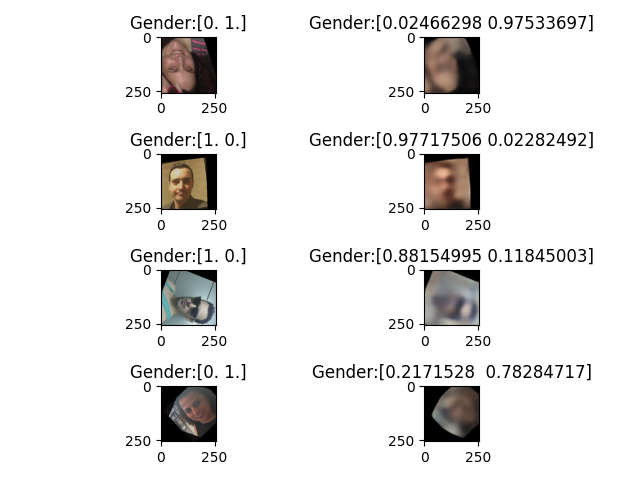

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [43]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [44]:
outTest = model(xTest)

In [45]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[5.75311899e-01, 3.71863246e-01, 3.98135036e-01],
          [2.17849910e-01, 1.23896152e-01, 2.97638029e-01],
          [2.89848447e-01, 1.29405856e-01, 2.13495344e-01],
          ...,
          [5.79924881e-02, 5.90108335e-02, 7.40808249e-02],
          [3.68884206e-02, 4.37584519e-02, 5.36607206e-02],
          [5.89348376e-02, 3.55280936e-02, 5.54998219e-02]],
 
         [[2.45444030e-01, 1.38000995e-01, 1.67624205e-01],
          [1.11470819e-01, 5.32427430e-02, 1.03574842e-01],
          [1.52934194e-01, 1.16342157e-01, 1.16144568e-01],
          ...,
          [5.47854602e-02, 5.12896478e-02, 7.42480159e-02],
          [6.51969016e-02, 6.49233162e-02, 8.31699371e-02],
          [4.66158986e-02, 5.25359809e-02, 4.51187789e-02]],
 
         [[1.21889859e-01, 9.48885083e-02, 2.18830258e-01],
          [1.05444342e-01, 9.12787020e-02, 1.72639936e-01],
          [1.51437074e-01, 1.98698938e-01, 1.46132559e-0

<IPython.core.display.Javascript object>


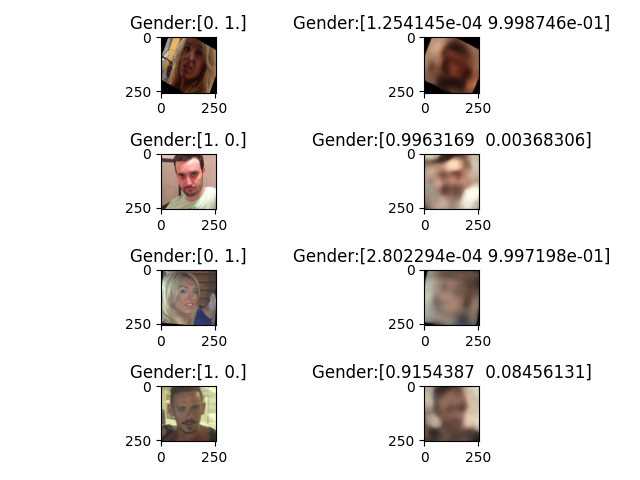

In [46]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()